In [1]:
#export
import pandas as pd
import numpy as np

In [2]:
DATA_LOC = '../data/'

## Standard for næringsgruppering (SN)
kilde: https://www.ssb.no/klass/klassifikasjoner/6

In [3]:
nace_2007 = pd.read_csv(DATA_LOC + '30.csv', sep=';', encoding='iso-8859-1') 
nace_2007.head(1)

,code,parentCode,level,name,shortName,notes,validFrom,validTo
0,01,A,2,"Jordbruk og tjenester tilknyttet jordbruk, jak...","Jordbruk, tilhør. tjenester, jakt",Inkluderer: Denne næringen omfatter to basisak...,NaN,NaN


## NACE (næringsgruppe) koder pr foretak

In [4]:
nace = pd.read_csv(DATA_LOC + 'EnhetNacekode.tab', sep='\t', encoding='utf-8', dtype={'nacekode': object}) 
nace_pivot = pd.pivot_table(nace.sort_values(by=['orgnr', 'rekkefolge']),
                            index='orgnr', columns='rekkefolge',
                            values='nacekode', aggfunc='first').reset_index()
nace_pivot.columns=['orgnr', 'nace_1', 'nace_2', 'nace_3','nace_4']
nace_pivot.head(1)

,orgnr,nace_1,nace_2,nace_3,nace_4
0,810033622,68.209,NaN,NaN,NaN


In [5]:
len(nace_pivot)

1070788

In [6]:
enhet = pd.read_csv(DATA_LOC + 'EnhetNavnOrgform.tab', sep='\t', encoding='iso-8859-1') 
enhet.head()

,orgnr,orgform,navn
0,810033622,AS,WILTHIL & CO AS
1,810034882,AS,SANDNES ELEKTRISKE FORRETNING AS
2,810059672,AS,AASEN & FARSTAD AS
3,810093382,AS,BRIS EIENDOM AS
4,810094532,AS,AGDERPOSTEN MEDIER AS


In [7]:
len(enhet)

1124902

## Beskrivelser for NACE kodene

In [8]:
nace_beskrivelse = pd.read_csv(DATA_LOC + 'nace_beskrivelse.tab', sep='\t', encoding='utf-8', dtype={'nacekode': object}) 
nace_beskrivelse.drop(['beskrivelse2'], axis=1, inplace=True)
nace_beskrivelse.columns = ['nace', 'tekst']

In [9]:
nace_beskrivelse.head()

,nace,tekst
0,00.000,Uoppgitt
1,01.110,"Dyrking av korn (unntatt ris), belgvekster og ..."
2,01.120,Dyrking av ris
3,01.130,"Dyrking av grønnsaker, meloner, rot- og knollv..."
4,01.140,Dyrking av sukkerrør


In [10]:
nace_beskrivelse.to_json(DATA_LOC + 'nace_beskrivelse.json', orient="records")

## Formålet med virksomheten beskrevet i tekst

In [11]:
formål = pd.read_csv(DATA_LOC + 'EnhetOrgformVirksomhetArtBransje.tab', sep='\t', encoding='iso-8859-1') 
formål.columns = ['orgnr', 'orgform', 'linje_nr', 'linje_tekst']

In [12]:
len(formål)

1901937

In [13]:
formål.head(5)

,orgnr,orgform,linje_nr,linje_tekst
0,810033622,AS,1,"Handel, engros og detalj og agenturer, herunder"
1,810033622,AS,2,import av varer.
2,810034882,AS,10,"Handel og innstallasjonsvirksomhet, eller anne..."
3,810034882,AS,20,"med dette, samt delta I annen virksomhet."
4,810059672,AS,10,Utleie av forretningseiendommer.


In [14]:
# eksempel: før sammenslåing
list(formål[formål['orgnr'] == 810034882]['linje_tekst'])

['Handel og innstallasjonsvirksomhet, eller annen virksomhet forbundet',
 'med dette, samt delta I annen virksomhet.']

In [15]:
# eksempel: etter sammenslåing
formål_t = formål[['orgnr','linje_tekst']].groupby('orgnr')['linje_tekst'].apply(lambda x: ' '.join(x)).reset_index()

In [16]:
list(formål_t[formål_t['orgnr'] == 810034882]['linje_tekst'])

['Handel og innstallasjonsvirksomhet, eller annen virksomhet forbundet med dette, samt delta I annen virksomhet.']

In [16]:
len(formål_t)

1102419

In [17]:
formål_t.head()

,orgnr,linje_tekst
0,810033622,"Handel, engros og detalj og agenturer, herunde..."
1,810034882,"Handel og innstallasjonsvirksomhet, eller anne..."
2,810059672,Utleie av forretningseiendommer.
3,810093382,"Eie og drift av fast eiendom, investering i ak..."
4,810094532,Utgi avisen Agderposten og drive annen virksom...


In [18]:
df = pd.merge(formål_t, nace_pivot, on='orgnr', how='inner') 

In [ ]:
# TODO: drop konkurser, ukjent osv

In [19]:
len(df)

1049701

## Datasett for maskinlæring

In [20]:
import spacy
import re

# laster spåkmodell fra norsk_spacy (nb! denne er ikke publisert offentlig enda og vil ikke fungere utenfor NAV)
nlp = spacy.load('nb_ud_ner')

def tokenize(x):
    tokens = nlp.tokenizer(x)
    return [t.text.lower() for t in tokens if not t.is_punct]

In [21]:
# test
tokenize('Handel og innstallasjonsvirksomhet, eller annen virksomhet forbundet med dette, samt delta I annen virksomhet.')

['handel',
 'og',
 'innstallasjonsvirksomhet',
 'eller',
 'annen',
 'virksomhet',
 'forbundet',
 'med',
 'dette',
 'samt',
 'delta',
 'i',
 'annen',
 'virksomhet']

In [22]:
#export
def get_dataset(row):
    s = row['linje_tekst']
    tokens = tokenize(s)
    tokens.append(f"__label__{row['nace_1']}")
    linje = ' '.join(tokens)
    return linje

In [23]:
dataset = df.apply(get_dataset, axis=1)

In [24]:
dataset.head(5)

0    handel engros og detalj og agenturer herunder ...
1    handel og innstallasjonsvirksomhet eller annen...
2      utleie av forretningseiendommer __label__68.209
3    eie og drift av fast eiendom investering i aks...
4    utgi avisen agderposten og drive annen virksom...
dtype: object

In [25]:
len(dataset)

1049701

In [26]:
dataset.iloc[0]

'handel engros og detalj og agenturer herunder import av varer __label__68.209'

In [27]:
# oppdeling av datasettet i 90% trening, 10% validering
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.1)
#train, test = np.split(dataset.sample(frac=1), [int(.9*len(dataset))])

In [28]:
train.to_csv(DATA_LOC + 'næringskoder_train.txt',
                                       header = None,
                                      index = None,
                                      sep = ' ', encoding='utf-8')

In [29]:
test.to_csv(DATA_LOC + 'næringskoder_test.txt',
                                       header = None,
                                      index = None,
                                      sep = ' ', encoding='utf-8')

## Trene modell 

In [30]:
#export
import fastText
from fastText import train_supervised, tokenize, load_model, unicode_literals

In [31]:
# list metoder
# dir(fastText)

In [38]:
#export
model = train_supervised(
    input = DATA_LOC + 'næringskoder_train.txt',
    wordNgrams = 3,
    label = '__label__',
    verbose = 2,
    minCount = 1,
    neg = 10
)

In [40]:
# list metoder
# dir(model)

In [41]:
model.save_model(DATA_LOC + 'nace_model.bin')
model.quantize(DATA_LOC + 'nace_model_quantized.bin')

In [42]:
#export
def print_results(N,p,r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1,p))
    print("R@{}\t{:.3f}".format(1,r))

In [43]:
print_results(*model.test(DATA_LOC + 'næringskoder_validate.txt'))

N	55683
P@1	0.658
R@1	0.658


In [46]:
#export
def predict_nace(model, tekst, k):
    res = {}
    res['nace'] = []
    pred = model.predict(tekst, k=k)
    for index, item in enumerate(pred[0]):
        res['nace'].append({'nace': item.replace('__label__', ''), 'prob': pred[1][index] })
    return res

In [59]:
tekst = test.iloc[400][:-16]
print(tekst)

kjøp og salg av eiendom investering i aksjer konsulentvirksomhet og ellers delta i andre selskaper


In [60]:
predict_nace(model, tekst, 5)

{'nace': [{'nace': '68.100"', 'prob': 0.1252400428056717},
  {'nace': '68.209"', 'prob': 0.11506573110818863},
  {'nace': '41.200"', 'prob': 0.1033470630645752},
  {'nace': '71.121"', 'prob': 0.06042535975575447},
  {'nace': '41.109"', 'prob': 0.0455712229013443}]}

In [65]:
test.values

array(['borettslag __label__68.201',
       'omsetning av gullsmedartikler __label__47.772',
       'salg og utvikling av kurs konferanse aktivitets og opplevelsespakke samt delta i annen næringsvirksomhet __label__93.210',
       ...,
       'it konsultasjon webutvikling og cms systemer __label__62.020',
       'maskiner og utstyr konsulenttjenester utvikling produksjon og salg __label__71.129',
       'oppstalling og trening av travhest __label__01.620'], dtype=object)

In [98]:
test.values[:10]

array(['borettslag __label__68.201',
       'omsetning av gullsmedartikler __label__47.772',
       'salg og utvikling av kurs konferanse aktivitets og opplevelsespakke samt delta i annen næringsvirksomhet __label__93.210',
       'investeringer i verdipapirer andeler og andre finansielle produkter __label__00.000',
       'landslaget for matematikk i skolen bodø lokallag er et partipolitisk uavhengig lokallag formålet for landslaget er å heve kvaliteten på matematikkopplæring i barnehagen grunnskolen i den videregående skole og på universitet høyskole __label__94.991',
       'salg og markedsføring av kaffe kafé produkter og mat for selskapet zinzino etter mlm multi level marketing prinsippet samt salgs organisasjonsbygging drift vedlikehold og motivasjon av salgsorganisasjon __label__47.990',
       'billedkunstner jobber med arbeider for utstillinger oppdrag utsmykkinger __label__90.031',
       'handel med maskiner og utstyr til industri __label__46.620',
       'dame og herre fris

In [109]:
pred_list=[]
for index, row in enumerate(test.values):
    nace = row[-6:]
    line = row[:-16]
    length = len(line)
    if (length > 1):
        pred = predict_nace(model, line,3)
        pred_1 = pred['nace'][0]['nace'][-7:-1]
        pred_2 = pred['nace'][1]['nace'][-7:-1]
        pred_3 = pred['nace'][2]['nace'][-7:-1]

        korrekt = 'Nei'
        if pred_1 == nace:
            korrekt = 'Ja'

        if nace in [pred_2,pred_3]:
            korrekt = 'Delvis'

        pred_list.append([index, nace, korrekt, pred_1, pred_2, pred_3,line])
    else:
        print(row)
        
pred = pd.DataFrame(pred_list)
pred.columns=['index','nace','korrekt','pred_1','pred_2','pred_3','tekst']

__label__84.110


In [110]:
len(pred)

104970

In [111]:
pred.head()

,index,nace,korrekt,pred_1,pred_2,pred_3,tekst
0,0,68.201,Ja,68.201,97.000,81.101,borettslag
1,1,47.772,Nei,03.211,01.490,10.110,omsetning av gullsmedartikler
2,2,93.210,Nei,85.599,70.220,56.101,salg og utvikling av kurs konferanse aktivitet...
3,3,00.000,Ja,00.000,64.308,68.209,investeringer i verdipapirer andeler og andre ...
4,4,94.991,Ja,94.991,94.120,88.995,landslaget for matematikk i skolen bodø lokall...


In [112]:
resultat = pred[['index', 'nace','korrekt']].groupby(['nace','korrekt']).count().reset_index()

In [113]:
resultat.head()

,nace,korrekt,index
0,00.000,Delvis,500
1,00.000,Ja,395
2,00.000,Nei,686
3,01.110,Delvis,288
4,01.110,Ja,701


In [114]:
pv = pd.pivot_table(resultat, index='nace', columns='korrekt').reset_index()
pv.columns = ['nace', 'delvis_korrekt','korrekt','feil']
pv['antall'] = pv['feil'] + pv['korrekt'] + pv['delvis_korrekt']
pv['andel_korrekt'] = 100 * pv['korrekt'] / pv['antall']
pv['andel_delvis_korrekt'] = 100 * (pv['korrekt'] + pv['delvis_korrekt']) / pv['antall']
pv.fillna(0, inplace = True)
pv.sort_values(by='antall', ascending = False, inplace=True) 

## Andel korrekte fastsettelser

In [115]:
pd.merge(pv,nace_beskrivelse, how='left', on='nace' ).head(10)

,nace,delvis_korrekt,korrekt,feil,antall,andel_korrekt,andel_delvis_korrekt,tekst
0,68.209,1020.0,4768.0,719.0,6507.0,73.274935,88.950361,Utleie av egen eller leid fast eiendom ellers
1,94.991,545.0,4569.0,499.0,5613.0,81.400321,91.109923,Aktiviteter i andre interesseorganisasjoner ik...
2,41.200,597.0,2218.0,360.0,3175.0,69.858268,88.661417,Oppføring av bygninger
3,70.220,470.0,1575.0,618.0,2663.0,59.143823,76.793090,Bedriftsrådgivning og annen administrativ rådg...
4,90.011,279.0,2005.0,195.0,2479.0,80.879387,92.133925,Utøvende kunstnere og underholdningsvirksomhet...
5,71.129,295.0,1000.0,409.0,1704.0,58.685446,75.997653,Annen teknisk konsulentvirksomhet
6,49.410,232.0,1252.0,213.0,1697.0,73.777254,87.448438,Godstransport på vei
7,64.308,492.0,898.0,252.0,1642.0,54.689403,84.652862,Investeringsselskaper og lignende lukket for a...
8,86.909,237.0,1238.0,155.0,1630.0,75.950920,90.490798,Andre helsetjenester
9,00.000,500.0,395.0,686.0,1581.0,24.984187,56.609741,Uoppgitt


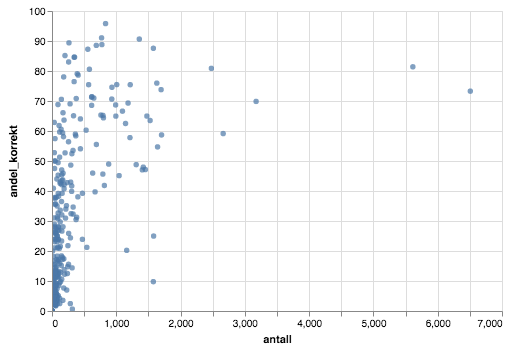

In [116]:
import pdvega
pv.vgplot.scatter(x='antall', y='andel_korrekt')

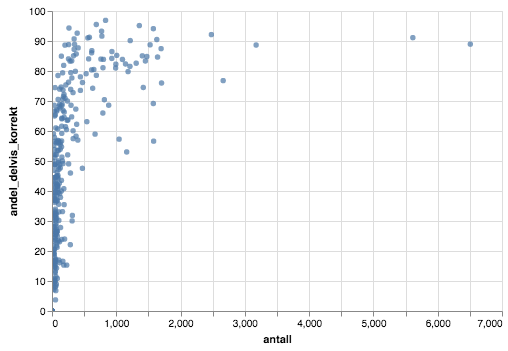

In [117]:
pv.vgplot.scatter(x='antall', y='andel_delvis_korrekt')

In [118]:
data = pd.merge(pred,nace_beskrivelse, how='left', on='nace')
data = data.rename(columns={'nace_beskrivelse':'nace_tekst'})
data.head(10)

,index,nace,korrekt,pred_1,pred_2,pred_3,tekst_x,tekst_y
0,0,68.201,Ja,68.201,97.000,81.101,borettslag,Borettslag
1,1,47.772,Nei,03.211,01.490,10.110,omsetning av gullsmedartikler,Butikkhandel med gull- og sølvvarer
2,2,93.210,Nei,85.599,70.220,56.101,salg og utvikling av kurs konferanse aktivitet...,Drift av fornøyelses- og temaparker
3,3,00.000,Ja,00.000,64.308,68.209,investeringer i verdipapirer andeler og andre ...,Uoppgitt
4,4,94.991,Ja,94.991,94.120,88.995,landslaget for matematikk i skolen bodø lokall...,Aktiviteter i andre interesseorganisasjoner ik...
5,5,47.990,Ja,47.990,47.919,73.110,salg og markedsføring av kaffe kafé produkter ...,Detaljhandel utenom utsalgssted ellers
6,6,90.031,Ja,90.031,90.020,90.012,billedkunstner jobber med arbeider for utstill...,Selvstendig kunstnerisk virksomhet innen visue...
7,7,46.620,Nei,46.694,46.630,46.693,handel med maskiner og utstyr til industri,Engroshandel med maskinverktøy
8,8,96.020,Ja,96.020,47.710,96.040,dame og herre frisør,Frisering og annen skjønnhetspleie
9,9,68.209,Ja,68.209,68.100,41.200,kjøp utleie forvaltning og salg av eiendom,Utleie av egen eller leid fast eiendom ellers


In [119]:
data = pd.merge(data,nace_beskrivelse, how='left', left_on='pred_1', right_on='nace', suffixes=['','_pred_1'])
data = pd.merge(data,nace_beskrivelse, how='left', left_on='pred_2', right_on='nace', suffixes=['','_pred_2'])
data = pd.merge(data,nace_beskrivelse, how='left', left_on='pred_3', right_on='nace', suffixes=['','_pred_3'])

In [120]:
from IPython.display import display
display(data)

,index,nace,korrekt,pred_1,pred_2,pred_3,tekst_x,tekst_y,nace_pred_1,tekst,nace_pred_2,tekst_pred_2,nace_pred_3,tekst_pred_3
0,0,68.201,Ja,68.201,97.000,81.101,borettslag,Borettslag,68.201,Borettslag,97.000,Lønnet arbeid i private husholdninger,81.101,Vaktmestertjenester
1,1,47.772,Nei,03.211,01.490,10.110,omsetning av gullsmedartikler,Butikkhandel med gull- og sølvvarer,03.211,Produksjon av matfisk og skalldyr i hav- og ky...,01.490,Husdyrhold ellers,10.110,Bearbeiding og konservering av kjøtt
2,2,93.210,Nei,85.599,70.220,56.101,salg og utvikling av kurs konferanse aktivitet...,Drift av fornøyelses- og temaparker,85.599,Annen undervisning ikke nevnt annet sted,70.220,Bedriftsrådgivning og annen administrativ rådg...,56.101,Drift av restauranter og kafeer
3,3,00.000,Ja,00.000,64.308,68.209,investeringer i verdipapirer andeler og andre ...,Uoppgitt,00.000,Uoppgitt,64.308,Investeringsselskaper og lignende lukket for a...,68.209,Utleie av egen eller leid fast eiendom ellers
4,4,94.991,Ja,94.991,94.120,88.995,landslaget for matematikk i skolen bodø lokall...,Aktiviteter i andre interesseorganisasjoner ik...,94.991,Aktiviteter i andre interesseorganisasjoner ik...,94.120,Yrkessammenslutninger,88.995,Sosiale velferdsorganisasjoner
5,5,47.990,Ja,47.990,47.919,73.110,salg og markedsføring av kaffe kafé produkter ...,Detaljhandel utenom utsalgssted ellers,47.990,Detaljhandel utenom utsalgssted ellers,47.919,Postordre-/Internetthandel med annet spesialis...,73.110,Reklamebyråer
6,6,90.031,Ja,90.031,90.020,90.012,billedkunstner jobber med arbeider for utstill...,Selvstendig kunstnerisk virksomhet innen visue...,90.031,Selvstendig kunstnerisk virksomhet innen visue...,90.020,Tjenester tilknyttet underholdningsvirksomhet,90.012,Utøvende kunstnere og underholdningsvirksomhet...
7,7,46.620,Nei,46.694,46.630,46.693,handel med maskiner og utstyr til industri,Engroshandel med maskinverktøy,46.694,Engroshandel med maskiner og utstyr til handel...,46.630,Engroshandel med maskiner og utstyr til bergve...,46.693,Engroshandel med maskiner og utstyr til indust...
8,8,96.020,Ja,96.020,47.710,96.040,dame og herre frisør,Frisering og annen skjønnhetspleie,96.020,Frisering og annen skjønnhetspleie,47.710,Butikkhandel med klær,96.040,Virksomhet knyttet til kroppspleie og fysisk v...
9,9,68.209,Ja,68.209,68.100,41.200,kjøp utleie forvaltning og salg av eiendom,Utleie av egen eller leid fast eiendom ellers,68.209,Utleie av egen eller leid fast eiendom ellers,68.100,Kjøp og salg av egen fast eiendom,41.200,Oppføring av bygninger


In [121]:
print(f"Antall: {len(data[data['nace']=='46.150'])}")
data[data['nace']=='46.150']

Antall: 66


,index,nace,korrekt,pred_1,pred_2,pred_3,tekst_x,tekst_y,nace_pred_1,tekst,nace_pred_2,tekst_pred_2,nace_pred_3,tekst_pred_3
449,449,46.150,Nei,47.591,47.599,46.471,import og omsetning av møbler kjøkken og inter...,"Agenturhandel med møbler, husholdningsvarer og...",47.591,Butikkhandel med møbler,47.599,Butikkhandel med innredningsartikler ikke nevn...,46.471,Engroshandel med møbler
482,482,46.150,Nei,79.903,47.789,56.101,salg av ulike produkter,"Agenturhandel med møbler, husholdningsvarer og...",79.903,"Opplevelses-, arrangements- og aktivitetsarran...",47.789,Butikkhandel ikke nevnt annet sted,56.101,Drift av restauranter og kafeer
5530,5530,46.150,Ja,46.150,46.180,46.160,agenturer for møbler,"Agenturhandel med møbler, husholdningsvarer og...",46.150,"Agenturhandel med møbler, husholdningsvarer og...",46.180,Agenturhandel med spesialisert vareutvalg ellers,46.160,"Agenturhandel med tekstiler, klær, pelsskinn, ..."
7076,7076,46.150,Nei,47.430,95.210,59.110,hvitevarer tv video og radio,"Agenturhandel med møbler, husholdningsvarer og...",47.430,Butikkhandel med audio- og videoutstyr,95.210,Reparasjon av elektronikk til husholdningsbruk,59.110,"Produksjon av film, video og fjernsynsprogrammer"
8915,8915,46.150,Nei,00.000,82.990,46.180,agenturvirksomhet,"Agenturhandel med møbler, husholdningsvarer og...",00.000,Uoppgitt,82.990,Annen forretningsmessig tjenesteyting ikke nev...,46.180,Agenturhandel med spesialisert vareutvalg ellers
10853,10853,46.150,Nei,47.761,96.020,47.789,handelsvirksomhet med salg av innredning og sk...,"Agenturhandel med møbler, husholdningsvarer og...",47.761,Butikkhandel med blomster og planter,96.020,Frisering og annen skjønnhetspleie,47.789,Butikkhandel ikke nevnt annet sted
10919,10919,46.150,Nei,68.209,43.221,64.308,agenturvirksomhet og handel samt ved aksjetegn...,"Agenturhandel med møbler, husholdningsvarer og...",68.209,Utleie av egen eller leid fast eiendom ellers,43.221,Rørleggerarbeid,64.308,Investeringsselskaper og lignende lukket for a...
17060,17060,46.150,Nei,95.220,47.540,43.210,salg av hvitevarer og småvarer,"Agenturhandel med møbler, husholdningsvarer og...",95.220,Reparasjon av husholdningsvarer og hageredskaper,47.540,Butikkhandel med elektriske husholdningsapparater,43.210,Elektrisk installasjonsarbeid
19674,19674,46.150,Nei,41.200,43.221,71.121,agenturhandel med dykkerutstyr vedsalg avvirki...,"Agenturhandel med møbler, husholdningsvarer og...",41.200,Oppføring av bygninger,43.221,Rørleggerarbeid,71.121,Byggeteknisk konsulentvirksomhet
19816,19816,46.150,Ja,46.150,47.591,46.471,agenturhandel med møbler glass og keramiske va...,"Agenturhandel med møbler, husholdningsvarer og...",46.150,"Agenturhandel med møbler, husholdningsvarer og...",47.591,Butikkhandel med møbler,46.471,Engroshandel med møbler


In [122]:
print(f"Antall: {len(data[data['nace']=='41.200'])}")
data[data['nace']=='41.200']

Antall: 3175


,index,nace,korrekt,pred_1,pred_2,pred_3,tekst_x,tekst_y,nace_pred_1,tekst,nace_pred_2,tekst_pred_2,nace_pred_3,tekst_pred_3
91,91,41.200,Ja,41.200,01.451,43.341,oppføring av bygninger,Oppføring av bygninger,41.200,Oppføring av bygninger,01.451,Sauehold,43.341,Malerarbeid
118,118,41.200,Ja,41.200,43.320,43.341,renovering av hus,Oppføring av bygninger,41.200,Oppføring av bygninger,43.320,Snekkerarbeid,43.341,Malerarbeid
122,122,41.200,Ja,41.200,81.210,43.341,oppføring av bygninger samt andre tjenester og...,Oppføring av bygninger,41.200,Oppføring av bygninger,81.210,Rengjøring av bygninger,43.341,Malerarbeid
137,137,41.200,Ja,41.200,68.209,41.109,bygging og restaurering av hus investering i f...,Oppføring av bygninger,41.200,Oppføring av bygninger,68.209,Utleie av egen eller leid fast eiendom ellers,41.109,Utvikling og salg av egen fast eiendom ellers
316,316,41.200,Ja,41.200,43.320,43.341,oppføring av bygninger byggearbeid håndverktje...,Oppføring av bygninger,41.200,Oppføring av bygninger,43.320,Snekkerarbeid,43.341,Malerarbeid
382,382,41.200,Ja,41.200,43.320,41.109,rehabilitering oppussing oppføring av boliger ...,Oppføring av bygninger,41.200,Oppføring av bygninger,43.320,Snekkerarbeid,41.109,Utvikling og salg av egen fast eiendom ellers
410,410,41.200,Nei,71.121,74.901,68.310,konsulentvirksomhet og jeg selger arbeidstimer...,Oppføring av bygninger,71.121,Byggeteknisk konsulentvirksomhet,74.901,Takseringsvirksomhet,68.310,Eiendomsmegling
430,430,41.200,Delvis,71.121,41.200,43.320,monteringsarbeider innen bygg og anlegg restau...,Oppføring av bygninger,71.121,Byggeteknisk konsulentvirksomhet,41.200,Oppføring av bygninger,43.320,Snekkerarbeid
432,432,41.200,Ja,41.200,43.320,71.121,håndverkstjenester innenfor bygg og anlegg,Oppføring av bygninger,41.200,Oppføring av bygninger,43.320,Snekkerarbeid,71.121,Byggeteknisk konsulentvirksomhet
443,443,41.200,Nei,01.410,01.420,01.190,storfehold og melkeproduksjon tømmermannsarbeid,Oppføring av bygninger,01.410,Melkeproduksjon på storfe,01.420,Oppdrett av annet storfe,01.190,Dyrking av ettårige vekster ellers


In [123]:
print(f"Antall: {len(data[data['nace']=='94.991'])}")
data[data['nace']=='94.991']

Antall: 5613


,index,nace,korrekt,pred_1,pred_2,pred_3,tekst_x,tekst_y,nace_pred_1,tekst,nace_pred_2,tekst_pred_2,nace_pred_3,tekst_pred_3
4,4,94.991,Ja,94.991,94.120,88.995,landslaget for matematikk i skolen bodø lokall...,Aktiviteter i andre interesseorganisasjoner ik...,94.991,Aktiviteter i andre interesseorganisasjoner ik...,94.120,Yrkessammenslutninger,88.995,Sosiale velferdsorganisasjoner
25,25,94.991,Ja,94.991,68.320,88.995,skal fremja medlemene sine felles interesser o...,Aktiviteter i andre interesseorganisasjoner ik...,94.991,Aktiviteter i andre interesseorganisasjoner ik...,68.320,Eiendomsforvaltning,88.995,Sosiale velferdsorganisasjoner
84,84,94.991,Ja,94.991,88.995,85.599,informasjonsformidling og kontaktskapende arbe...,Aktiviteter i andre interesseorganisasjoner ik...,94.991,Aktiviteter i andre interesseorganisasjoner ik...,88.995,Sosiale velferdsorganisasjoner,85.599,Annen undervisning ikke nevnt annet sted
86,86,94.991,Nei,90.011,90.012,90.020,floorknights family er et artist kompani som d...,Aktiviteter i andre interesseorganisasjoner ik...,90.011,Utøvende kunstnere og underholdningsvirksomhet...,90.012,Utøvende kunstnere og underholdningsvirksomhet...,90.020,Tjenester tilknyttet underholdningsvirksomhet
114,114,94.991,Ja,94.991,68.320,93.120,leggja til rette for grendahusfunksjon i tidli...,Aktiviteter i andre interesseorganisasjoner ik...,94.991,Aktiviteter i andre interesseorganisasjoner ik...,68.320,Eiendomsforvaltning,93.120,Idrettslag og -klubber
121,121,94.991,Ja,94.991,68.320,94.120,norway kazakhstan chamber of commerce and indu...,Aktiviteter i andre interesseorganisasjoner ik...,94.991,Aktiviteter i andre interesseorganisasjoner ik...,68.320,Eiendomsforvaltning,94.120,Yrkessammenslutninger
140,140,94.991,Ja,94.991,68.320,42.110,velforening vedlikehold av vei i hyttefelt,Aktiviteter i andre interesseorganisasjoner ik...,94.991,Aktiviteter i andre interesseorganisasjoner ik...,68.320,Eiendomsforvaltning,42.110,Bygging av veier og motorveier
146,146,94.991,Ja,94.991,93.120,88.995,klubb for personer som liker amerikanske biler...,Aktiviteter i andre interesseorganisasjoner ik...,94.991,Aktiviteter i andre interesseorganisasjoner ik...,93.120,Idrettslag og -klubber,88.995,Sosiale velferdsorganisasjoner
150,150,94.991,Delvis,90.011,94.991,88.999,kor for mennesker med særlige behov,Aktiviteter i andre interesseorganisasjoner ik...,90.011,Utøvende kunstnere og underholdningsvirksomhet...,94.991,Aktiviteter i andre interesseorganisasjoner ik...,88.999,Andre sosialtjenester uten botilbud
170,170,94.991,Ja,94.991,88.995,94.120,vennskapsforening sosialt og kulturelt norsk b...,Aktiviteter i andre interesseorganisasjoner ik...,94.991,Aktiviteter i andre interesseorganisasjoner ik...,88.995,Sosiale velferdsorganisasjoner,94.120,Yrkessammenslutninger


In [124]:
writer = pd.ExcelWriter(DATA_LOC + 'prediksjon.xlsx')
data.to_excel(writer,'prediksjon')
writer.save()